In [1]:
import gc
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from importlib import reload
from pandas import Timestamp
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator, metocean

try:
    map_

except NameError:
    map_ = plot.get_map()

In [2]:
plt.rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [3]:
import matplotlib.font_manager
import os
fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontList.json"))

fm.findfont("serif", rebuild_if_missing=False)

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


'/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [4]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Root Mean Square Algorithm

$for\:i=0, 1, 2, \dots n:$<BR>
<BLOCKQUOTE>$\epsilon_i = \sqrt{(x_i^* - x_i)^2 + (y_i^* - y_i)^2}$</BLOCKQUOTE><BR>
$\mu_{\epsilon} = \sum_{i=0}^{n}\frac{\epsilon_i}{n}$  

In [5]:

def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

In [6]:
def plot_observed_and_optimized_tracks(xs, ys, ref_xs, ref_ys):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    ax.plot(xs, ys, color='grey')

    ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')
    
    legend_handles = [Line2D([0], [0], color='grey', label='Simulated'),
                      Line2D([0], [0], color='w', marker='^', markersize=8, markerfacecolor='k', label='Observed')] 

    ax.legend(handles=legend_handles, facecolor='w', framealpha=1)
    
    return fig, ax

In [7]:
def plot_spaghetti(xs, ys, ref_xs, ref_ys):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    for x, y in zip(xs, ys):
        ax.plot(x, y, color='grey')

    ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')
    
    return fig, ax

In [8]:
def plot_spaghetti2(xs, ys, ref_xs, ref_ys, best_xs, best_ys):

    fig, ax = plt.subplots(1, 1)
    ax.set_aspect('equal')
    ax.margins(x=0.1, y=0.6)

    for x, y in zip(xs, ys):

        ax.plot(x, y, color='grey', label='')

    ax.scatter(ref_xs, ref_ys, color='k', marker='^', zorder=1000)
    ax.plot(best_xs, best_ys, 'k:', zorder=999)

    legend_handles = [Line2D([0], [0], color='grey', label='Simulated'),
                      Line2D([0], [0], color='k', linestyle=':', label='Best simulated'),
                      Line2D([0], [0], color='w', marker='^', markersize=8, 
                             markerfacecolor='k', label='Observed')] 


    ax.legend(handles=legend_handles, loc='upper left')

    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')

    return fig, ax

In [9]:
def pcolor_optimization_results(Cas, Cws, errs, optimal_Ca, optimal_Cw):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    plt.pcolor(Cas - np.mean(np.diff(Cas)) / 2, Cws - np.mean(np.diff(Cws)) / 2 , 
               errs.reshape(len(Cas) - 1, len(Cws) - 1))

    ax.set_xticks(Cas[:-1])
    ax.set_yticks(Cws[:-1])

    ax.scatter(optimal_Ca, optimal_Cw, marker='x', color='white')

    plt.xlabel(r'$C_a$')
    plt.ylabel(r'$C_w$')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel('Error (km)', rotation=90)
    
    return fig, ax

In [10]:
def plot_probabilistic_map(XYZ, xys, ref_xys=None, cbar_step=0.1):
    
    X, Y, Z = XYZ
    x_data, y_data = xys
    ref_x, ref_y  = ref_xys
    
    n_levels = np.arange(0, 1 + cbar_step, cbar_step)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    if ref_xys:
        plt.scatter(ref_x, ref_y, color='black', zorder=1000, label='observed', marker='^')
    
    plt.contourf(X, Y, Z, n_levels, alpha=0.7)

    plt.plot(x_data.T, y_data.T, 'k-',  alpha=0.2, linewidth=1.5)
    plt.plot(np.mean(x_data, 0), np.mean(y_data, 0), 'k', linestyle='--', linewidth=2, label='mean')
      
    plt.xlabel('Position (km)')
    plt.ylabel('Position (km)')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel('Probability', rotation=90)
    
    legend_handles = [Line2D([0], [0], color='grey', label='Simulated'),
                      Line2D([0], [0], color='k', linestyle='--', label='Mean simulated'),
                      Line2D([0], [0], color='w', marker='^', markersize=8, 
                         markerfacecolor='k', label='Observed')] 


    ax.legend(handles=legend_handles, facecolor='w', framealpha=1)
    
    return fig, ax 

In [11]:
def plot_observed_track(xs, ys):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.margins(x=0.2, y=0.4)
    ax.scatter(ref_xs, ref_ys, marker='^', c='black')
    ax.annotate(xy=(ref_xs[0], ref_ys[0]), s='start', xytext=(0, -0.8))
    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')
    
    return fig, ax

In [12]:
def plot_metocean_field(m, tc, field, velocity_field, field_name='ocean'):
    
    if field_name == 'ocean':
        
        field_lons = field.longitude.values
        field_lats = field.latitude.values
        field_times = field.time.values
        cbar_label = 'Current speed (m/s)'
        cmap = 'viridis'
        vmin = 0
        vmax = 0.5
        arrow_scale = 0.05
        index_0 = 0
        index_12 = 11
        index_24 = 23

        num_grid_cells = 20
        
    elif field_name == 'atmosphere':
        
        field_lons = field.longitude.values[:-1]
        field_lats = field.latitude.values
        field_times = field.time.values
        cbar_label = 'Wind speed (m/s)'
        cmap = 'plasma'
        vmin = 0
        vmax = 15
        arrow_scale = 0.8
        index_0 = 0
        index_12 = 3
        index_24 = -1
        
        num_grid_cells = 6
    
    start_x, start_y = m(tc.start_longitude, tc.start_latitude)

    field_xs, field_ys = m(field_lons, field_lats)
    berg_xs, berg_ys = m(tc.ref_lons.values, tc.ref_lats.values)

    field_xs -= start_x
    field_ys -= start_y
    field_xs /= 1000
    field_ys /= 1000

    berg_xs -= start_x
    berg_ys -= start_y
    berg_xs /= 1000
    berg_ys /= 1000

    x_index = np.argmin(abs(field_xs))
    x_index_0 = x_index - num_grid_cells // 2
    x_index_n = x_index + num_grid_cells // 2

    y_index = np.argmin(abs(field_ys))
    y_index_0 = y_index - num_grid_cells // 2
    y_index_n = y_index + num_grid_cells // 2

    velocities = velocity_field.eastward_velocities.values
    us_0 = velocities[index_0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    us_12 = velocities[index_12, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    us_24 = velocities[index_24, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

    velocities = velocity_field.northward_velocities.values
    vs_0 = velocities[index_0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    vs_12 = velocities[index_12, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    vs_24 = velocities[index_24, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

    xs = field_xs[x_index_0 : x_index_n + 1]
    ys = field_ys[y_index_0 : y_index_n + 1]

    xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
    ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 1.7), sharey=True, num='wind')
    
    u = us_0
    v = vs_0
    axs[0].set_xlabel('Position (km)')
    axs[0].set_ylabel('Position (km)')
    for ax, u, v, label in zip(axs, [us_0, us_12, us_24], [vs_0, vs_12, vs_24], ['a)', 'b)', 'c)']):
        ax.set_aspect('equal')
        ax.pcolor(xxs, yys, np.sqrt(u**2 + v**2), cmap=cmap, vmin=vmin, vmax=vmax)
        ax.quiver(xs, ys, u, v, units='xy', angles='xy', color='white', scale=arrow_scale, zorder=1000)
        ax.scatter(berg_xs, berg_ys, marker='^', color='k', s=1)
        ax.set_ylim(-50, 50)
        ax.set_xlim(-50, 50)
        ax.set_xticks([-25, 0, 25])
        ax.set_yticks([-25, 0, 25])
        ax.text(-0.05, 1.15, label, transform=ax.transAxes, va='top', ha='right')

    cm = ax.get_children()[0]
    cbar = fig.colorbar(cm)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(f'{cbar_label}', rotation=90)

    fig.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axs

# Run



Day 1




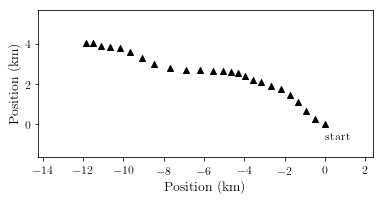

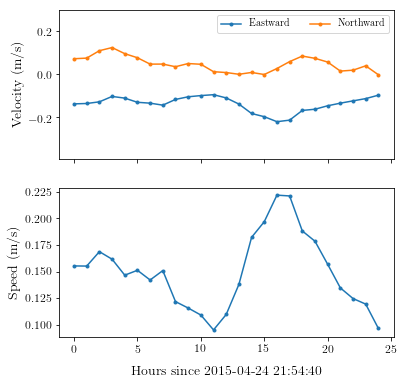

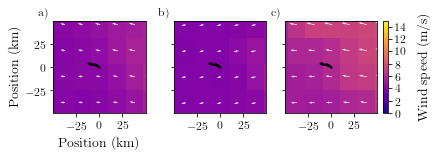

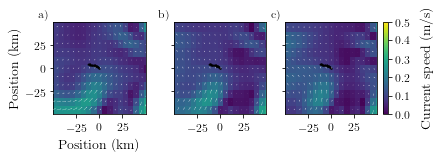

Optimizing Ca and Cw...
Optimal: RMSE = 0.9985375757401996, Ca = 1.0, Cw = 1.0


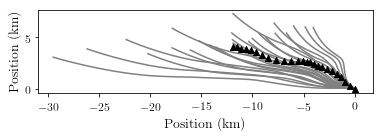

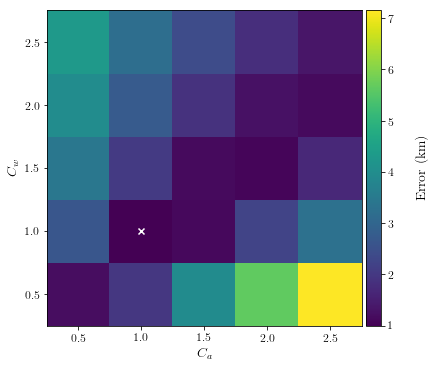

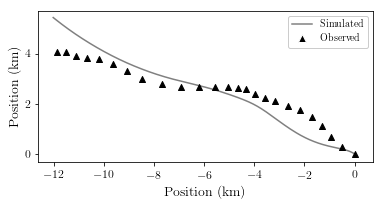

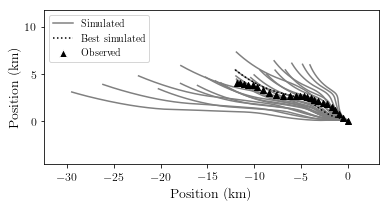

Running ensemble...


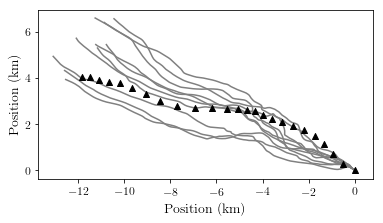

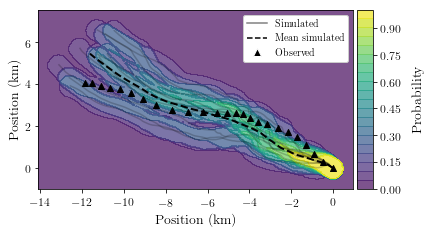

In [56]:
default = False

start_day = 1
num_days = 1
days = [day for day in range(start_day, start_day + num_days)]

beacon_id = '90679'  # good berg
#beacon_id = '50519'  # bad berg

df = sd.get_beacon_df(beacon_id=beacon_id)

all_results = {}
total_distances = {}

smoothing_constant = 0.2

for day in days:
    
    for default in [False]:
        
        results = {}
    
        if default:
            print(f'\n\nDay {day} - Default\n\n')
        else:
            print(f'\n\nDay {day}\n\n')
    
        if beacon_id == '90679':
            start_index = 816
        elif beacon_id == '50519':
            start_index = 537

        start_time = df.DataDate_UTC.values[start_index]
        start_time += np.timedelta64(day - 1, 'D')
        end_time = start_time + np.timedelta64(25, 'h')

        tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

        ref_times, ref_lats, ref_lons = tc.ref_times, tc.ref_lats.values, tc.ref_lons.values
        ref_xs, ref_ys = np.array(map_(ref_lons, ref_lats)) / 1000
        ref_x0 = ref_xs[0]
        ref_y0 = ref_ys[0]
        ref_xs -= ref_xs[0]
        ref_ys -= ref_ys[0]

        sim_args = tc.time_frame, tc.start_location, tc.start_velocity
        sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
        sim.testcase = tc
        sim.results.map = map_ 
        reference_data_dict = {'time': ref_times, 'latitude': ref_lats, 'longitude': ref_lons}
        sim.results.add_from_dict(reference_data_dict, label='reference')
        sim.results.add_xy_to_existing_dataset('reference')


        # Plot 1 - Observed drift track

        fig1, ax1 = plot_observed_track(ref_xs, ref_ys)
        plt.show()
        
        # Plot iceberg velocities
        
        ts = tc.ref_times
        xs, ys = map_(tc.ref_lons.values, tc.ref_lats.values)

        us = np.empty(len(ts))
        vs = np.empty(len(ts))
        us[0] = tc.start_velocity[0]
        vs[0] = tc.start_velocity[1]

        for i in range(1, len(ts)):
            dt = np.timedelta64((ts[i] - ts[i-1]), 's').item().total_seconds()
            us[i] = (xs[i] - xs[i-1]) / dt
            vs[i] = (ys[i] - ys[i-1]) / dt

        distances = np.empty(len(ts) - 1)
        for i in range(1, len(ts)): 
            distances[i-1] = np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2)
        total_distance = np.sum(distances)
        total_distance /= 1000
        total_distances[f'day{day}'] = total_distance

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

        ax1.plot(us, '.-', label='Eastward')
        ax1.plot(vs, '.-', label='Northward')
        ax1.margins(y=0.5)
        ax1.set_ylabel('Velocity (m/s)')
        ax1.legend(ncol=2)

        ax2.plot(np.sqrt(us**2 + vs**2), '.-')
        ax2.set_xlabel('Hours since 2015-04-24 21:54:40', labelpad=10)
        ax2.set_ylabel('Speed (m/s)')

        fig.savefig('./plots/day1_velocity_time_graph.pdf', bbox_inches='tight')

        plt.show()


        # Plot 2 - Current and wind velocities

        fig2a, ax2a = plot_metocean_field(map_, tc, sim.atmosphere.data, sim.atmosphere.wind, field_name='atmosphere')
        plt.show()
        fig2b, ax2b = plot_metocean_field(map_, tc, sim.ocean.data, sim.ocean.current, field_name='ocean')
        plt.show()

        
        
        
        print('Optimizing Ca and Cw...')

        Ca, Cw = None, None

        if default:
            run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}

        else:
            run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                          'perturb_current': True, 'perturb_wind': True,
                          'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

        n = 5
        N = n**2

        Cas = np.linspace(0.5, 2.5, n)
        Cws = np.linspace(0.5, 2.5, n)
        
        Ca_mesh, Cw_mesh = np.meshgrid(Cas, Cws)
        
        ref_xs_ = sim.results.data['reference']['easting']
        ref_ys_ = sim.results.data['reference']['northing']
        
        err_dict = {'Ca': np.zeros(N), 'Cw': np.zeros(N), 'err': np.zeros(N)}
        all_xs = []
        all_ys = []
        
        for i in range(N):                

            label = str(i)
            
            Ca = Ca_mesh.flatten()[i]
            Cw = Cw_mesh.flatten()[i]
            
            run_sim_kwargs['Ca'] = Ca
            run_sim_kwargs['Cw'] = Cw

        
            sim.run_simulation(label=label, **run_sim_kwargs)
            sim.results.add_xy_to_existing_dataset(label)
            
            xs = sim.results.data[label]['easting']
            ys = sim.results.data[label]['northing']
            
            all_xs.append(xs - ref_x0)
            all_ys.append(ys - ref_y0)

            err = calc_mean_error((ys, xs), (ref_ys_, ref_xs_))
            
            err_dict['Ca'][i] = Ca
            err_dict['Cw'][i] = Cw
            err_dict['err'][i] = err
            
        index = np.argmin(err_dict['err'][:])
        min_err = err_dict['err'][index]
        optimal_Ca = err_dict['Ca'][index]
        optimal_Cw = err_dict['Cw'][index]

        print(f'Optimal: RMSE = {min_err}, Ca = {optimal_Ca}, Cw = {optimal_Cw}')

        Cas = np.append(Cas, Cas[-1] + np.mean(np.diff(Cas)))
        Cws = np.append(Cws, Cws[-1] + np.mean(np.diff(Cws)))

        # Plot 3 - Optimization results

        fig3a, ax3a = plot_spaghetti(all_xs, all_ys, ref_xs, ref_ys)
        plt.show()
        fig3b, ax3b = pcolor_optimization_results(Cas, Cws, err_dict['err'], optimal_Ca, optimal_Cw)
        plt.show()

        xs = sim.results.data[str(index)]['easting'].values - ref_x0
        ys = sim.results.data[str(index)]['northing'].values - ref_y0

        fig3c, ax3c = plot_observed_and_optimized_tracks(xs, ys, ref_xs, ref_ys)
        plt.show()

        fig3d, ax3d = plot_spaghetti2(all_xs, all_ys, ref_xs, ref_ys, xs, ys)
        plt.show()
        
        
        labels = [str(i) for i in range(N)]
        for label in labels:
            sim.results.remove_dataset(label)



        print('Running ensemble...')

        Ca, Cw = optimal_Ca, optimal_Cw

        if default:
            run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}

        else:
            run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 
                              'smoothing_constant': smoothing_constant}

        N = 10

        for i in range(N):

            sim.run_simulation(label=f'{i}', **run_sim_kwargs)

        labels = [str(i) for i in range(N)]

        all_xs = []
        all_ys = []

        for label in labels:

            sim.results.add_xy_to_existing_dataset(label)
            xs = sim.results.data[label]['easting'].values - ref_x0
            ys = sim.results.data[label]['northing'].values - ref_y0
            results[label] = calc_mean_error((sim.results.data[label]['northing'], sim.results.data[label]['easting']), 
                                             (ref_ys_, ref_xs_))
            all_xs.append(xs)
            all_ys.append(ys)
        
        all_results[f'day{day}'] = results

        # Plot 4 - Ensemble spaghetti

        fig4, ax4 = plot_spaghetti(all_xs, all_ys, ref_xs, ref_ys)
        plt.show()


        # Plot 5 - Cones

        rd = sim.results.data

        x_data = []
        y_data = []

        for i, label in enumerate(labels):
            x_data.append(rd[label]['easting'].values - ref_x0)
            y_data.append(rd[label]['northing'].values - ref_y0)

        x_data = np.array(x_data)
        y_data = np.array(y_data)

        r = 0.5
        dx = 0.05
        dy = 0.05

        pad = 1 
        xlim_left = np.min(np.append(x_data, ref_xs)) - pad
        xlim_right = np.max(np.append(x_data, ref_xs)) + pad
        ylim_left = np.min(np.append(y_data, ref_ys)) - pad
        ylim_right = np.max(np.append(y_data, ref_ys)) + pad
        X, Y = np.mgrid[xlim_left : xlim_right : dy, ylim_left : ylim_right : dy]
        Z = np.zeros_like(X, dtype='int')

        for x, y in zip(x_data, y_data):
            Z_ = np.zeros_like(Z)
            for x_, y_ in zip(x, y):
                Z_[np.sqrt((X+dx/2-x_)**2 + (Y+dy/2-y_)**2) < r] = 1
            Z += Z_

        # divide by the realizations to come up with a probability
        m = len(labels)
        Z = Z / m

        fig5a, ax5a = plot_probabilistic_map((X, Y, Z), (x_data, y_data), (ref_xs, ref_ys), 0.05)
        plt.show()


        if default:
            run_type = '_default'
        else:
            run_type = ''
        #ax1.set_title(f'Day {day} - Figure 1')
        fig1.savefig(f'./plots/day{day}_figure1{run_type}.pdf', bbox_inches='tight')
        #ax2a[0].set_title(f'Day {day} - Figure 2a')
        fig2a.savefig(f'./plots/day{day}_figure2a{run_type}.pdf', bbox_inches='tight')
        #ax2b[0].set_title(f'Day {day} - Figure 2b')
        fig2b.savefig(f'./plots/day{day}_figure2b{run_type}.pdf', bbox_inches='tight')
        #ax3a.set_title(f'Day {day} - Figure 3a')
        fig3a.savefig(f'./plots/day{day}_figure3a{run_type}.pdf', bbox_inches='tight')
        #ax3b.set_title(f'Day {day} - Figure 3b')
        fig3b.savefig(f'./plots/day{day}_figure3b{run_type}.pdf', bbox_inches='tight')
        #ax3c.set_title(f'Day {day} - Figure 3c')
        fig3c.savefig(f'./plots/day{day}_figure3c{run_type}.pdf', bbox_inches='tight')
        fig3d.savefig(f'./plots/day{day}_figure3d{run_type}.pdf', bbox_inches='tight')
        #ax4.set_title(f'Day {day} - Figure 4')
        fig4.savefig(f'./plots/day{day}_figure4{run_type}.pdf', bbox_inches='tight')
        #ax5a.set_title(f'Day {day} - Figure 5a')
        fig5a.savefig(f'./plots/day{day}_figure5a{run_type}.pdf', bbox_inches='tight')
        #ax5b.set_title(f'Day {day} - Figure 5b')
        #fig5b.savefig(f'./plots/day{day}_figure5b{run_type}.pdf', bbox_inches='tight')  

        del sim
        del tc

        gc.collect()

In [67]:
x_indices = []
y_indices = []
for ref_x, ref_y in zip(ref_xs, ref_ys):
    x_index = np.argmin(abs(X[:, 0] - ref_x))
    y_index = np.argmin(abs(Y[0, :] - ref_y))
    x_indices.append(x_index)
    y_indices.append(y_index)
x_indices = np.array(x_indices)
y_indices = np.array(y_indices)

In [68]:
probabilities = []
for x_index, y_index in zip(x_indices, y_indices):
    probabilities.append(Z[x_index, y_index])
probabilities = np.array(probabilities)

Mean probability = 0.452


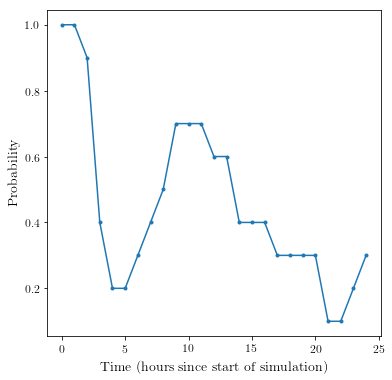

In [69]:
mean_probability = np.mean(probabilities)
print(f'Mean probability = {mean_probability}')
plt.plot(probabilities, '.-')
plt.ylabel('Probability')
plt.xlabel('Time (hours since start of simulation)')
plt.show()

In [30]:
min_rmses = []
mean_rmses = []

for day in days:
    rmses = []
    for i in range(10):
        rmses.append(np.array(all_results[f'day{day}'][str(i)]))
    min_rmses.append(np.min(rmses))
    mean_rmses.append(np.mean(rmses))
    
min_rmses = np.array(min_rmses)
mean_rmses = np.array(mean_rmses)

Smoothing constant = 0.2


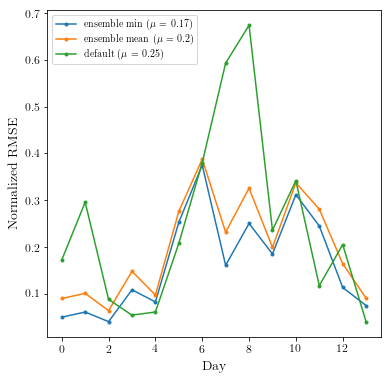

In [31]:
print(f'Smoothing constant = {smoothing_constant}')

normalize = True

if beacon_id == '90679':
    rmses = np.array([0.999, 1.30, 0.500, 3.10, 2.38, 7.01, 15.0, 3.71, 2.95, 4.13, 7.73, 5.58, 1.68, 2.64])
    default_rmses = np.array([2.22, 3.81, 1.02, 1.12, 1.62, 5.50, 14.7, 9.01, 5.83, 4.82, 7.34, 2.29, 1.88, 1.18])

elif beacon_id == '50519':
    rmses = np.array([8.56, 1.12, 2.46, 4.32, 6.56, 4.75, 15.3, 12.34, 19.1, 13.1, 11.4, 9.01, 6.13, 2.14])
    default_rmses = np.array([6.48, 2.89, 3.62, 4.13, 6.13, 3.72, 14.75, 12.80, 18.3, 11.8, 11.3, 5.99, 5.37, 1.02])
    
if normalize:
    
    for i, day in enumerate(days):
        min_rmses[i] /= total_distances[f'day{day}']
        mean_rmses[i] /= total_distances[f'day{day}']
        default_rmses[i] /= total_distances[f'day{day}']
    
mean_min_rmse = np.round(np.mean(min_rmses), 2)
mean_mean_rmse = np.round(np.mean(mean_rmses), 2)
mean_default_rmse = np.round(np.mean(default_rmses), 2)

plt.plot(min_rmses, '.-', label=fr'Ensemble min ($\mu$ = {mean_min_rmse})')
plt.plot(mean_rmses, '.-', label=fr'Ensemble mean ($\mu$ = {mean_mean_rmse})')
plt.plot(default_rmses, '.-', label=fr'Default ($\mu$ = {mean_default_rmse})')

if normalize:
    plt.ylabel('Normalized RMSE')
else:
    plt.ylabel('RMSE (km)')
    
plt.xlabel('Day')
plt.legend()
plt.show()

## Smoothing Constant = 0.6

Smoothing constant = 0.6


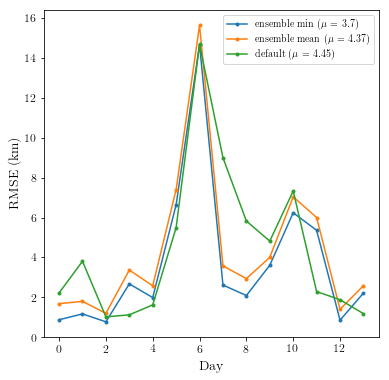

In [33]:
print(f'Smoothing constant = {smoothing_constant}')

if beacon_id == '90679':
    rmses = np.array([0.999, 1.30, 0.500, 3.10, 2.38, 7.01, 15.0, 3.71, 2.95, 4.13, 7.73, 5.58, 1.68, 2.64])
    default_rmses = np.array([2.22, 3.81, 1.02, 1.12, 1.62, 5.50, 14.7, 9.01, 5.83, 4.82, 7.34, 2.29, 1.88, 1.18])

elif beacon_id == '50519':
    rmses = np.array([8.56, 1.12, 2.46, 4.32, 6.56, 4.75, 15.3, 12.34, 19.1, 13.1, 11.4, 9.01, 6.13, 2.14])
    default_rmses = np.array([6.48, 2.89, 3.62, 4.13, 6.13, 3.72, 14.75, 12.80, 18.3, 11.8, 11.3, 5.99, 5.37, 1.02])
    
mean_min_rmse = np.round(np.mean(min_rmses), 2)
mean_mean_rmse = np.round(np.mean(mean_rmses), 2)
mean_default_rmse = np.round(np.mean(default_rmses), 2)

plt.plot(min_rmses, '.-', label=fr'ensemble min ($\mu$ = {mean_min_rmse})')
plt.plot(mean_rmses, '.-', label=fr'ensemble mean ($\mu$ = {mean_mean_rmse})')
plt.plot(default_rmses, '.-', label=fr'default ($\mu$ = {mean_default_rmse})')
plt.ylabel('RMSE (km)')
plt.xlabel('Day')
plt.legend()
plt.show()

## Smoothing Constant = 0.4

Smoothing constant = 0.4


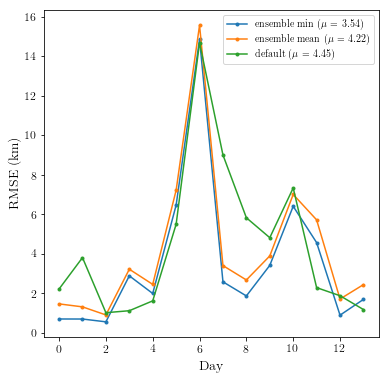

In [30]:
print(f'Smoothing constant = {smoothing_constant}')

if beacon_id == '90679':
    rmses = np.array([0.999, 1.30, 0.500, 3.10, 2.38, 7.01, 15.0, 3.71, 2.95, 4.13, 7.73, 5.58, 1.68, 2.64])
    default_rmses = np.array([2.22, 3.81, 1.02, 1.12, 1.62, 5.50, 14.7, 9.01, 5.83, 4.82, 7.34, 2.29, 1.88, 1.18])

elif beacon_id == '50519':
    rmses = np.array([8.56, 1.12, 2.46, 4.32, 6.56, 4.75, 15.3, 12.34, 19.1, 13.1, 11.4, 9.01, 6.13, 2.14])
    default_rmses = np.array([6.48, 2.89, 3.62, 4.13, 6.13, 3.72, 14.75, 12.80, 18.3, 11.8, 11.3, 5.99, 5.37, 1.02])
    
mean_min_rmse = np.round(np.mean(min_rmses), 2)
mean_mean_rmse = np.round(np.mean(mean_rmses), 2)
mean_default_rmse = np.round(np.mean(default_rmses), 2)

plt.plot(min_rmses, '.-', label=fr'ensemble min ($\mu$ = {mean_min_rmse})')
plt.plot(mean_rmses, '.-', label=fr'ensemble mean ($\mu$ = {mean_mean_rmse})')
plt.plot(default_rmses, '.-', label=fr'default ($\mu$ = {mean_default_rmse})')
plt.ylabel('RMSE (km)')
plt.xlabel('Day')
plt.legend()
plt.show()

## Smoothing Constant = 0.2

Smoothing constant = 0.2


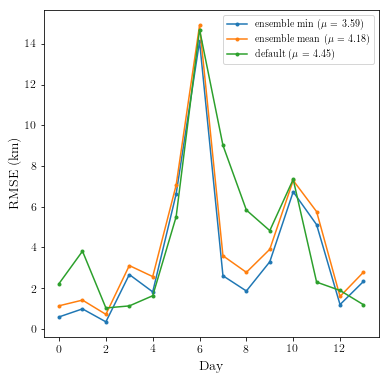

In [27]:
print(f'Smoothing constant = {smoothing_constant}')

if beacon_id == '90679':
    rmses = np.array([0.999, 1.30, 0.500, 3.10, 2.38, 7.01, 15.0, 3.71, 2.95, 4.13, 7.73, 5.58, 1.68, 2.64])
    default_rmses = np.array([2.22, 3.81, 1.02, 1.12, 1.62, 5.50, 14.7, 9.01, 5.83, 4.82, 7.34, 2.29, 1.88, 1.18])

elif beacon_id == '50519':
    rmses = np.array([8.56, 1.12, 2.46, 4.32, 6.56, 4.75, 15.3, 12.34, 19.1, 13.1, 11.4, 9.01, 6.13, 2.14])
    default_rmses = np.array([6.48, 2.89, 3.62, 4.13, 6.13, 3.72, 14.75, 12.80, 18.3, 11.8, 11.3, 5.99, 5.37, 1.02])
    
mean_min_rmse = np.round(np.mean(min_rmses), 2)
mean_mean_rmse = np.round(np.mean(mean_rmses), 2)
mean_default_rmse = np.round(np.mean(default_rmses), 2)

plt.plot(min_rmses, '.-', label=fr'ensemble min ($\mu$ = {mean_min_rmse})')
plt.plot(mean_rmses, '.-', label=fr'ensemble mean ($\mu$ = {mean_mean_rmse})')
plt.plot(default_rmses, '.-', label=fr'default ($\mu$ = {mean_default_rmse})')
plt.ylabel('RMSE (km)')
plt.xlabel('Day')
plt.legend()
plt.show()

In [ ]:
plt.plot(rmses - default_rmses, '.-')

In [ ]:
bob

# Merge PDFs

In [ ]:
files = []

for day in days:
    
    files.append(f'./plots/day{day}_figure1.pdf')
    files.append(f'./plots/day{day}_figure2a.pdf')
    files.append(f'./plots/day{day}_figure2b.pdf')
    files.append(f'./plots/day{day}_figure3a.pdf')
    files.append(f'./plots/day{day}_figure3b.pdf')
    files.append(f'./plots/day{day}_figure3c.pdf')
    files.append(f'./plots/day{day}_figure4.pdf')
    files.append(f'./plots/day{day}_figure5a.pdf')
        

In [ ]:
from PyPDF2 import PdfFileMerger

merger = PdfFileMerger()

for file in files:
    merger.append(file)

if beacon_id == '90679':
    merger.write(f"./plots/good_berg_day{days[0]}_to_day{days[-1]}.pdf")
    
elif beacon_id == '50519':
    merger.write(f"./plots/bad_berg_day{days[0]}_to_day{days[-1]}.pdf")


# Inset Map

In [ ]:
df

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

map = Basemap(projection='cyl', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='#7777ff')
map.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map.drawcoastlines()

lons = np.array([-13.7, -10.8, -13.2, -96.8, -7.99, 7.5, -17.3, -3.7])
lats = np.array([9.6, 6.3, 8.5, 32.7, 12.5, 8.9, 14.7, 40.39])
cases = np.array([1971, 7069, 6073, 4, 6, 20, 1, 1])
deaths = np.array([1192, 2964, 1250, 1, 5, 8, 0, 0])
places = np.array(['Guinea', 'Liberia', 'Sierra Leone','United States', 'Mali', 'Nigeria', 'Senegal', 'Spain'])

x, y = map(lons, lats)

map.scatter(x, y, s=cases, c='r', alpha=0.5)

axins = zoomed_inset_axes(ax, 7, loc=1)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=-20,llcrnrlat=3,urcrnrlon=0,urcrnrlat=18, ax=axins)
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(x, y, s=cases/5., c='r', alpha=0.5)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

In [ ]:
lats, lons = df['Latitude'].values, df['Longitude'].values

In [ ]:
plt.plot(lons, lats)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

map_drawn = plot.draw_map(map_)
x, y = map_(lons, lats)

map_drawn.plot(x, y)

In [ ]:
map_kwargs = plot.get_map_kwargs(min(lats), min(lons), max(lats), max(lons), pads=[7, 4, 5, 2])

In [ ]:
map_2 = plot.get_map(**map_kwargs)

In [ ]:
reload(plot)

In [ ]:
big_map = Basemap(projection='cyl',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-56,
                  llcrnrlat=46,
                  urcrnrlon=-48,
                  urcrnrlat=53.5,)




In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

big_map.drawcoastlines()
parallels = big_map.drawparallels(np.arange(0, 90, 2), labels=[1, 0, 0, 0])
meridians = big_map.drawmeridians(np.arange(0., 360., 2.), labels=[0, 0, 0, 1])
x, y = big_map(lons, lats)
big_map.plot(x, y)

ax.annotate(xy=(x[0], y[0]), xytext=(x[0]+0.2, y[0]-0.6), s='Start', 
            arrowprops=dict(facecolor='black', width=0.1, headwidth=4, headlength=4))

ax.annotate(xy=(x[-1], y[-1]), xytext=(x[-1]+0.2, y[-1]-0.6), s='End', 
            arrowprops=dict(facecolor='black', width=0.1, headwidth=4, headlength=4))

axins = zoomed_inset_axes(ax, 1.5, loc=1)
axins.set_xlim(-53, -51)
axins.set_ylim(51, 52)
#plt.xticks(visible=False)
#plt.yticks(visible=False)

inset_map = Basemap(projection='cyl',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-54,
                  llcrnrlat=51.03,
                  urcrnrlon=-51.61,
                  urcrnrlat=51.85,
                  ax=axins)

inset_map.drawcoastlines()
x, y = inset_map(lons, lats)
inset_map.scatter(x, y, s=1)
mark_inset(ax, axins, loc1=2, loc2=4)

plt.show()

In [ ]:
fig.savefig('./plots/good_berg_inset_map.pdf', bbox_inches='tight')

In [ ]:
tc.start_location

In [ ]:
tc2 = test_case.TestCase(beacon_id=beacon_id, start_time=start_time+np.timedelta64(14, 'D'), 
                         end_time=start_time+np.timedelta64(15, 'D'))

In [ ]:
tc2.start_location

In [ ]:
plt.plot(tc2.ref_lons.values, tc2.ref_lats.values)